In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/EV_Energy_Consumption_Dataset.csv")

In [4]:
seq_features = ["Speed_kmh", "Acceleration_ms2"]  # sequential/time features
static_features = ["Battery_State_%", "Battery_Voltage_V", "Battery_Temperature_C",
                   "Temperature_C", "Humidity_%", "Wind_Speed_ms", "Vehicle_Weight_kg"]  # static features

target_feature = "Energy_Consumption_kWh"

In [5]:
# Fill missing values
df[seq_features + static_features] = df[seq_features + static_features].fillna(0)
df = df.dropna(subset=[target_feature])

In [6]:
X_seq = df[seq_features].values.reshape((df.shape[0], 1, len(seq_features)))  # LSTM expects 3D
X_static = df[static_features].values
y = df[target_feature].values

In [7]:
# Scale features
scaler_seq = StandardScaler()
X_seq_scaled = scaler_seq.fit_transform(X_seq.reshape(-1, len(seq_features))).reshape(X_seq.shape)

scaler_static = StandardScaler()
X_static_scaled = scaler_static.fit_transform(X_static)

In [8]:
# Train/test split
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq_scaled, X_static_scaled, y, test_size=0.2, random_state=42
)

In [9]:
# Sequential input
seq_input = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]))
x = LSTM(64, activation='tanh')(seq_input)
x = Dropout(0.2)(x)

# Static input
static_input = Input(shape=(X_static_train.shape[1],))
y_static = Dense(64, activation='relu')(static_input)
y_static = Dropout(0.2)(y_static)

# Combine
combined = concatenate([x, y_static])
z = Dense(64, activation='relu')(combined)
z = Dense(32, activation='relu')(z)
output = Dense(1, activation='linear')(z)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,152 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,033 (109.50 KB)

 Trainable params: 28,033 (109.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit([X_seq_train, X_static_train], y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32)

# Save the model
model.save("ev_energy_model.h5")
print("Model saved!")


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 50.9363 - mean_absolute_error: 6.3400 - val_loss: 2.8489 - val_mean_absolute_error: 1.3559
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1146 - mean_absolute_error: 1.4100 - val_loss: 2.3058 - val_mean_absolute_error: 1.2165
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6001 - mean_absolute_error: 1.3077 - val_loss: 2.0058 - val_mean_absolute_error: 1.1370
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2492 - mean_absolute_error: 1.2158 - val_loss: 1.7476 - val_mean_absolute_error: 1.0704
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9837 - mean_absolute_error: 1.1506 - val_loss: 1.5732 - val_mean_absolute_error: 1.0211
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7587 - mean_absolute_error: 1.0918 - val_loss: 1.4859 - val_mean_absolute_error: 1.0020
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6475 - mean_absolute_error: 1.0478 

Model saved!


In [13]:
y_pred = model.predict([X_seq_test, X_static_test])

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # RMSE manually
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.9906
RMSE: 1.1867
R² Score: 0.7096


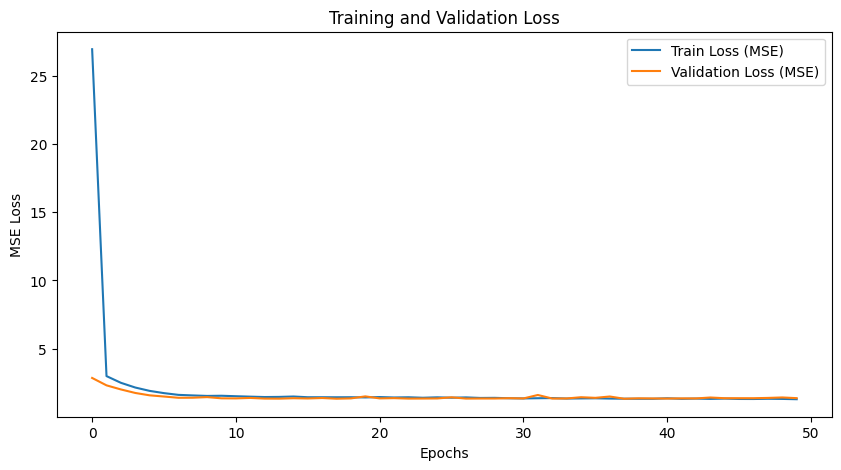

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


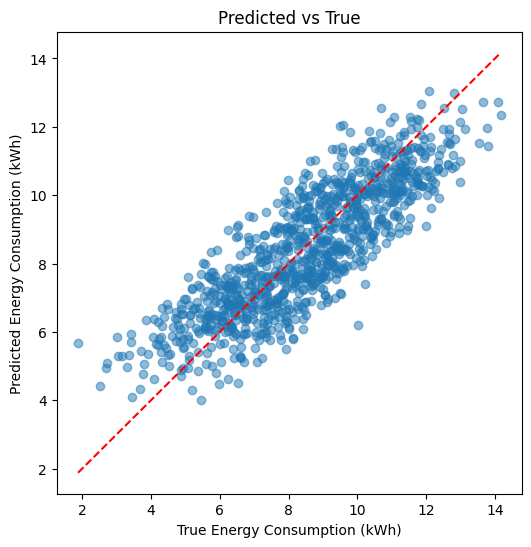

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Energy Consumption (kWh)')
plt.ylabel('Predicted Energy Consumption (kWh)')
plt.title('Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # y=x line
plt.show()